Simulating the population

In [ ]:
!pip install simglucose


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.8/157.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 941.1/941.1 kB 38.8 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.9.4-py3-none-any.whl size=215456 sha256=00fdee06c57e900d99c0d30a734169d89b008c2769f21e4f2436b638e9249ae2
  Stored in directory: /root/.cache/pip/wheels/73/79/5d/8207cd0f4418ba90fedb0c20c4680a3abf4cfee1b5d

In [ ]:
from simglucose.simulation.env import T1DSimEnv
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import timedelta

# Load patient parameters from CSV file
df = pd.read_csv("vpatient_params.csv")  # Adjust the file name as needed

# Set parameters
N_SAMPLE = 288  # Number of samples per day (5 min intervals)
Npat = len(df)  # Number of patients to simulate (from loaded data)
max_days = 10   # Number of days to simulate
path = "/content/output 2"  # Directory to save simulation results
start_time = timedelta(days=0)  # Starting time for the simulation as a timedelta
min_cgm_threshold = 40  # Minimum CGM threshold to check

# Create output directory if it doesn't exist
os.makedirs(path, exist_ok=True)

# Initialize storage
Vmx = []
CGM = np.empty((0, N_SAMPLE))
CHO = np.empty((0, N_SAMPLE))
insulin = np.empty((0, N_SAMPLE))
filename = []

# Simulate multiple patients
for pat in range(Npat):
    patname = df.iloc[pat]['Name']

    for rep in range(10):
        ##################################################################################################################
        # 1. Setup patient loading its parameters from file
        ##################################################################################################################
        patient = T1DPatient.withName(patname)

        # Add random variation to the Vmx value
        patient._params.Vmx += 0.003 * np.random.randn()
        patient_name = f'{patname}_{rep:02d}'

        print(f'Simulating: {patient_name}')

        ##################################################################################################################
        # 2. Setup CGM sensor and pump models
        ##################################################################################################################
        sensor = CGMSensor.withName('Dexcom', seed=1)
        pump = InsulinPump.withName('Insulet')

        ##################################################################################################################
        # 3. Setup custom meal pattern
        # Custom scenario is a list of tuples (time, meal_size)
        ##################################################################################################################
        prob = [0.95, 0.3, 0.95, 0.3, 0.95, 0.3]
        base_t = [7, 10, 12.5, 16, 20, 22]
        base_m = [10, 3, 20, 3, 20, 3]
        sigma_m = [2, 1, 3, 1, 3, 1]
        scen = []

        for d in range(max_days):
            for i in range(6):
                pmeal = np.random.uniform()
                if pmeal < prob[i]:
                    tm = (base_t[i] + (np.random.uniform() - 0.5) * 2) * 60 + d * 24 * 60
                    vm = max(0, base_m[i] + sigma_m[i] * np.random.randn())
                    scen.append((tm, vm))

        scenario = CustomScenario(start_time=start_time, scenario=scen)

        ##################################################################################################################
        # 4. Simulate the CGM measures
        ##################################################################################################################
        env = T1DSimEnv(patient, sensor, pump, scenario)
        env.patient.name = patient_name

        # Create a controller
        controller = BBController()

        # Put them together to create a simulation object
        s2 = SimObj(env, controller, timedelta(days=max_days), animate=False, path=path)
        s2.simulate()
        results2 = s2.env.show_history()

        cgm = results2.CGM
        if np.sum(cgm <= min_cgm_threshold) == 0:  # No CGM values below the threshold
            for n_days in range(max_days):
                patient_name = f'{patname}_{rep:02d}_day{n_days:02d}'

                start_ind = n_days * N_SAMPLE
                stop_ind = (n_days + 1) * N_SAMPLE

                Vmx.append(patient._params.Vmx)
                filename.append(patient_name)

                day_results = results2.iloc[start_ind:stop_ind]
                savename = os.path.join(path, f'{patient_name}.csv')
                day_results.to_csv(savename, index=False)

                CGM = np.vstack((CGM, day_results.CGM))
                CHO = np.vstack((CHO, day_results.CHO))  # Ensure CHO is available in the results
                insulin = np.vstack((insulin, day_results.insulin - day_results.insulin.iloc[0]))

# Save simulation parameters
simpar = pd.DataFrame()
simpar['Filename'] = filename
simpar['Vmx'] = Vmx
simpar.to_csv(os.path.join(path, "Population_parameters.csv"), index=False)

# Save numpy arrays
np.save(os.path.join(path, 'CGM_pop.npy'), CGM)
np.save(os.path.join(path, 'CHO_pop.npy'), CHO)
np.save(os.path.join(path, 'insulin_pop.npy'), insulin)
np.save(os.path.join(path, 'Vmx_pop.npy'), Vmx)

# Print summary of simulations
print(f"Generated simulations for {Npat} patients, each with 10 variations.")


Simulating: adolescent#001_00
Simulating: adolescent#001_01
Simulating: adolescent#001_02
Simulating: adolescent#001_03
Simulating: adolescent#001_04
Simulating: adolescent#001_05
Simulating: adolescent#001_06
Simulating: adolescent#001_07
Simulating: adolescent#001_08
Simulating: adolescent#001_09
Simulating: adolescent#002_00
Simulating: adolescent#002_01
Simulating: adolescent#002_02
Simulating: adolescent#002_03
Simulating: adolescent#002_04
Simulating: adolescent#002_05
Simulating: adolescent#002_06
Simulating: adolescent#002_07
Simulating: adolescent#002_08
Simulating: adolescent#002_09
Simulating: adolescent#003_00
Simulating: adolescent#003_01
Simulating: adolescent#003_02
Simulating: adolescent#003_03
Simulating: adolescent#003_04
Simulating: adolescent#003_05
Simulating: adolescent#003_06
Simulating: adolescent#003_07
Simulating: adolescent#003_08
Simulating: adolescent#003_09
Simulating: adolescent#004_00
Simulating: adolescent#004_01
Simulating: adolescent#004_02
Simulating

Data Preprocessing and Training


Training RandomForest...
RandomForest Performance:
MSE: 3.680346822722638e-06, MAE: 0.0010171387795049505, RMSE: 0.0019184230041163076, R2: 0.9963925262404931

Training LinearRegression...
LinearRegression Performance:
MSE: 0.0009978387574938363, MAE: 0.025145402096071554, RMSE: 0.031588585873600555, R2: 0.021919045331976195

Training SVR...
SVR Performance:
MSE: 0.001330749713944996, MAE: 0.03148631335199393, RMSE: 0.0364794423469575, R2: -0.30440007552779513

Training GradientBoosting...
GradientBoosting Performance:
MSE: 0.0003991990306920773, MAE: 0.015772262085726987, RMSE: 0.019979965733005582, R2: 0.6087053483245077
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.4278 - val_loss: 0.0012
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/100

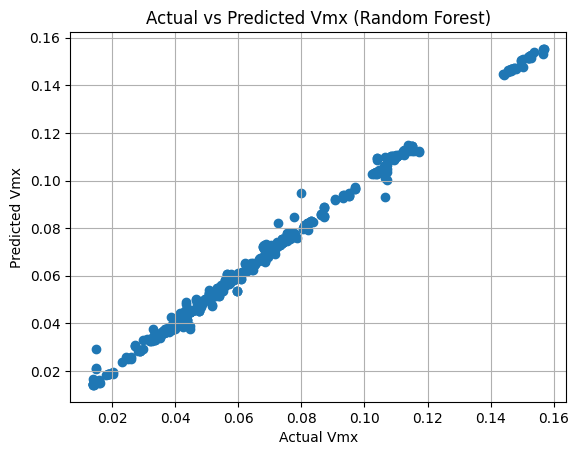

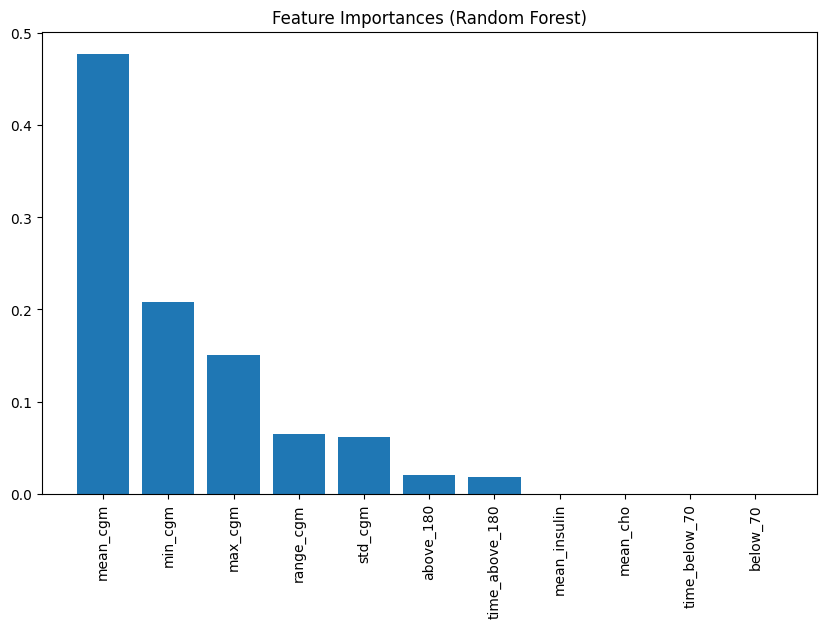

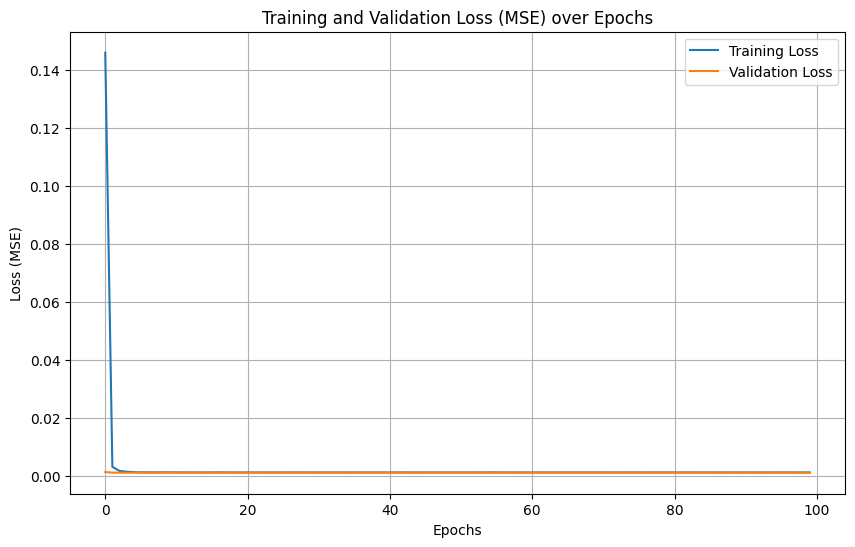

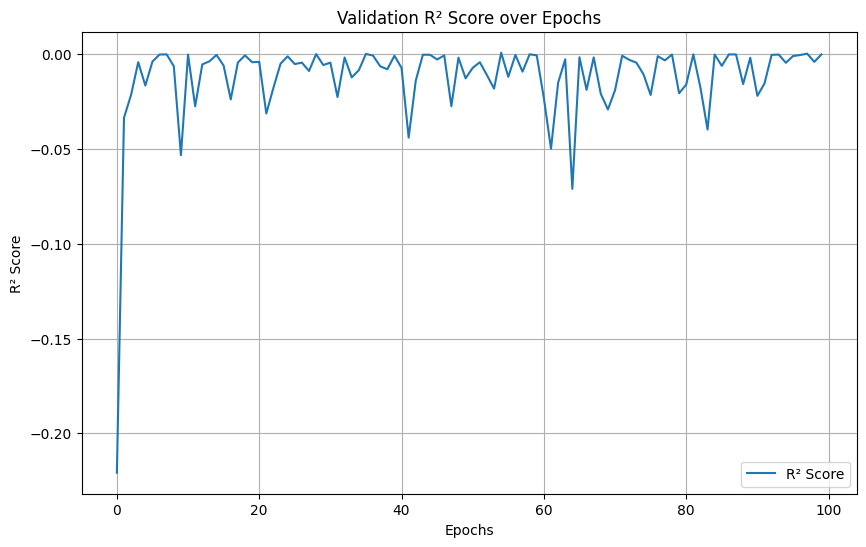

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import Callback
import matplotlib.pyplot as plt

# Load data
CGM = np.load('/content/drive/MyDrive/GCM/output_2/CGM_pop.npy')
CHO = np.load('/content/drive/MyDrive/GCM/output_2/CHO_pop.npy')
insulin = np.load('/content/drive/MyDrive/GCM/output_2/insulin_pop.npy')
Vmx = np.load('/content/drive/MyDrive/GCM/output_2/Vmx_pop.npy')

# Load patient parameters (for reference, but using Vmx for the model)
simpar = pd.read_csv('/content/drive/MyDrive/GCM/output_2/Population_parameters.csv')

# Feature extraction function
def extract_features(cgm_data):
    features = {
        'mean_cgm': np.mean(cgm_data),
        'std_cgm': np.std(cgm_data),
        'max_cgm': np.max(cgm_data),
        'min_cgm': np.min(cgm_data),
        'range_cgm': np.ptp(cgm_data),
        'above_180': np.sum(cgm_data > 180),
        'below_70': np.sum(cgm_data < 70),
        'time_above_180': np.mean(cgm_data > 180),
        'time_below_70': np.mean(cgm_data < 70)
    }
    return features

# Extract features from CGM data
feature_list = [extract_features(day_cgm) for day_cgm in CGM]
X = pd.DataFrame(feature_list)

# Add CHO and insulin features
X['mean_cho'] = np.mean(CHO, axis=1)
X['mean_insulin'] = np.mean(insulin, axis=1)

# Target variable
y = Vmx

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a list of models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'LinearRegression': LinearRegression(),
    'SVR': SVR(kernel='rbf'),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Initialize an empty list to store hyperparameters and evaluation metrics
hyperparameters = []

# Loop over models to train and evaluate
for model_name, model in models.items():
    print(f'\nTraining {model_name}...')

    # Train the model
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)

    # Evaluate performance
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f'{model_name} Performance:')
    print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R2: {r2}')

    # Store hyperparameters and performance metrics
    if hasattr(model, 'get_params'):
        params = model.get_params()
        params['model'] = model_name
        params['MSE'] = mse
        params['MAE'] = mae
        params['RMSE'] = rmse
        params['R2'] = r2
        hyperparameters.append(params)

# LSTM Model
def create_complex_lstm_model(input_shape):
    model = Sequential()
    # LSTM layers with Dropout
    model.add(LSTM(units=100, return_sequences=True, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False, activation='relu'))
    model.add(Dropout(0.2))
    # Fully connected layer
    model.add(Dense(50, activation='relu'))
    # Output layer
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Reshape data for LSTM
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

# Initialize the LSTM model
complex_lstm_model = create_complex_lstm_model((1, X_train.shape[1]))

# Custom callback to track R² score
class R2History(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.r2_scores = []

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred_lstm = self.model.predict(X_val)
        y_pred_lstm = y_pred_lstm.flatten()
        r2 = r2_score(y_val, y_pred_lstm)
        self.r2_scores.append(r2)

# Initialize the R² tracking callback
r2_history = R2History(validation_data=(X_test_lstm, y_test))

# Train the LSTM model
history = complex_lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=32,
                                 validation_data=(X_test_lstm, y_test), callbacks=[r2_history])

# Predict using the LSTM model
y_pred_complex_lstm = complex_lstm_model.predict(X_test_lstm)

# Evaluate LSTM model performance
mse_complex_lstm = mean_squared_error(y_test, y_pred_complex_lstm)
mae_complex_lstm = mean_absolute_error(y_test, y_pred_complex_lstm)
rmse_complex_lstm = np.sqrt(mse_complex_lstm)
r2_complex_lstm = r2_score(y_test, y_pred_complex_lstm)

print(f'\nComplex LSTM Performance:')
print(f'MSE: {mse_complex_lstm}, MAE: {mae_complex_lstm}, RMSE: {rmse_complex_lstm}, R2: {r2_complex_lstm}')

# Store LSTM hyperparameters and metrics
complex_lstm_params = {
    'layers': '2 LSTM layers + Dense layer',
    'units': [100, 50],
    'dropout': 0.2,
    'optimizer': 'adam',
    'learning_rate': 0.001,
    'epochs': 100,
    'batch_size': 32,
    'MSE': mse_complex_lstm,
    'MAE': mae_complex_lstm,
    'RMSE': rmse_complex_lstm,
    'R2': r2_complex_lstm,
    'model': 'Complex LSTM'
}

hyperparameters.append(complex_lstm_params)

# Save hyperparameters and evaluation metrics to CSV
hyperparams_df = pd.DataFrame(hyperparameters)
hyperparams_df.to_csv('model_hyperparameters.csv', index=False)

# Plot Actual vs Predicted for Random Forest
y_pred_rf = models['RandomForest'].predict(X_test)
plt.scatter(y_test, y_pred_rf)
plt.xlabel('Actual Vmx')
plt.ylabel('Predicted Vmx')
plt.title('Actual vs Predicted Vmx (Random Forest)')
plt.grid(True)
plt.show()

# Plot feature importance for Random Forest
importances = models['RandomForest'].feature_importances_
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), X.columns[sorted_indices], rotation=90)
plt.title('Feature Importances (Random Forest)')
plt.show()

# Plot Loss Curve for LSTM
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (MSE) over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Plot R² Score over Epochs
plt.figure(figsize=(10, 6))
plt.plot(r2_history.r2_scores, label='R² Score')
plt.title('Validation R² Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import Callback
import matplotlib.pyplot as plt

# Load data
CGM = np.load('/content/drive/MyDrive/GCM/output_2/CGM_pop.npy')
CHO = np.load('/content/drive/MyDrive/GCM/output_2/CHO_pop.npy')
insulin = np.load('/content/drive/MyDrive/GCM/output_2/insulin_pop.npy')
Vmx = np.load('/content/drive/MyDrive/GCM/output_2/Vmx_pop.npy')

# Load patient parameters (for reference, but using Vmx for the model)
simpar = pd.read_csv('/content/drive/MyDrive/GCM/output_2/Population_parameters.csv')

In [ ]:
simpar.head()

,Filename,Vmx
0,adolescent#001_00_day00,0.080596
1,adolescent#001_00_day01,0.080596
2,adolescent#001_00_day02,0.080596
3,adolescent#001_00_day03,0.080596
4,adolescent#001_00_day04,0.080596


In [ ]:
# Check the shape and basic statistics of each dataset
print("CGM Data Shape:", CGM.shape)
print("CHO Data Shape:", CHO.shape)
print("Insulin Data Shape:", insulin.shape)
print("Vmx Data Shape:", Vmx.shape)

# Load and describe the patient parameters
print("Patient Parameters Data:")
print(simpar.info())
print(simpar.describe())


CGM Data Shape: (3000, 288)
CHO Data Shape: (3000, 288)
Insulin Data Shape: (3000, 288)
Vmx Data Shape: (3000,)
Patient Parameters Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Filename  3000 non-null   object 
 1   Vmx       3000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 47.0+ KB
None
               Vmx
count  3000.000000
mean      0.069075
std       0.033010
min       0.013833
25%       0.044155
50%       0.062181
75%       0.082209
max       0.156803


Plot Actual vs Predicted

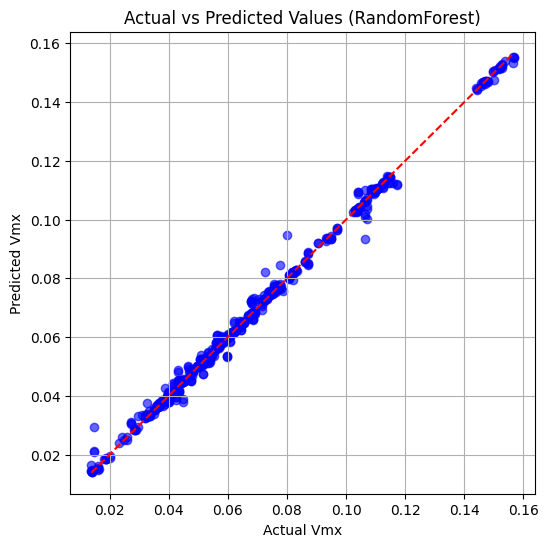

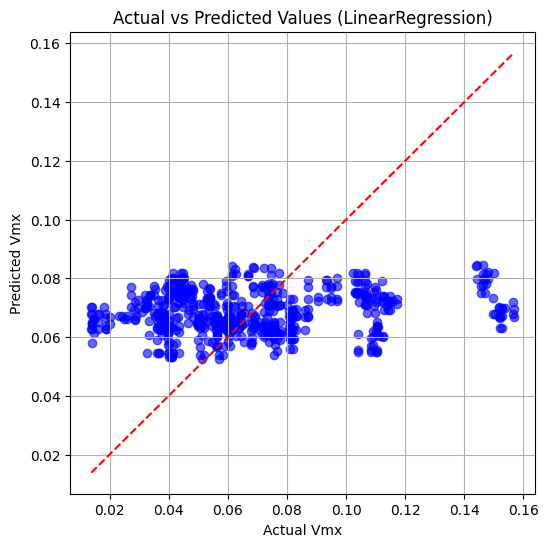

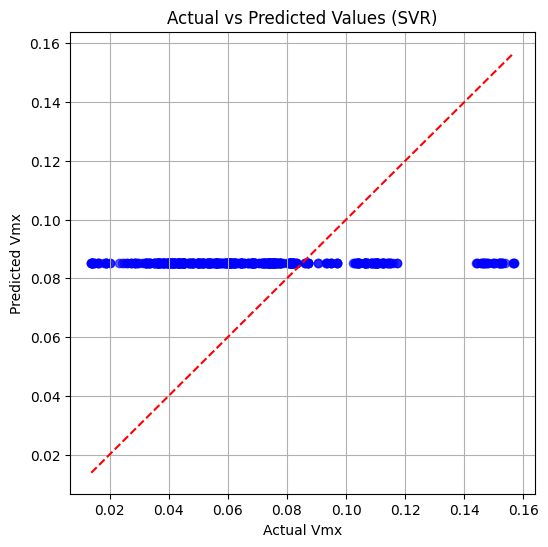

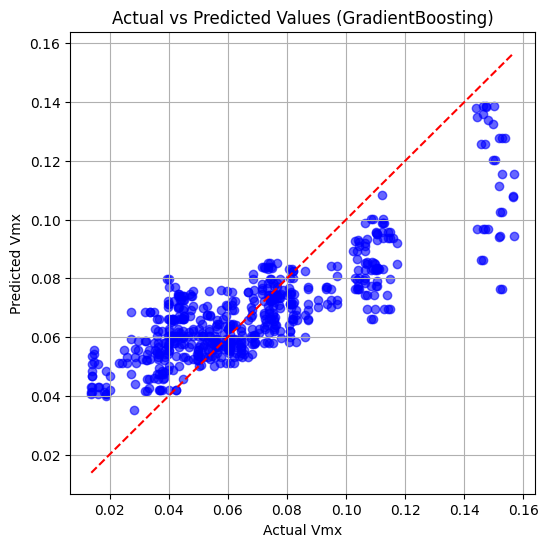

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


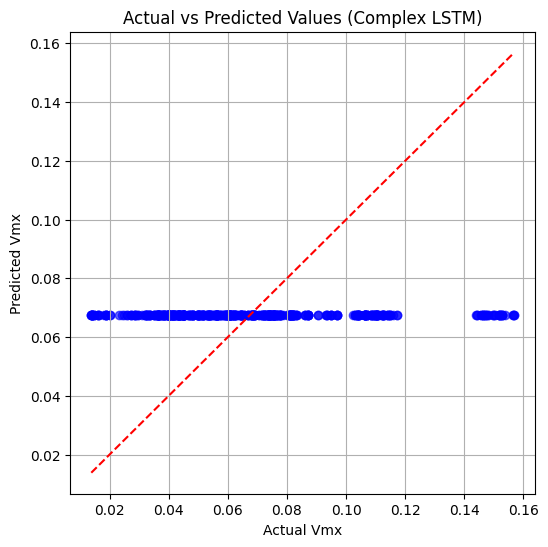

In [ ]:
import matplotlib.pyplot as plt

# Function to plot Actual vs Predicted values
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, color='b')  # Scatter plot of actual vs predicted
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Diagonal line for reference
    plt.title(f'Actual vs Predicted Values ({model_name})')
    plt.xlabel('Actual Vmx')
    plt.ylabel('Predicted Vmx')
    plt.grid(True)
    plt.show()

# Loop over the models and plot Actual vs Predicted for each
for model_name, model in models.items():
    # Get predictions for the test data
    y_pred = model.predict(X_test)

    # Plot actual vs predicted
    plot_actual_vs_predicted(y_test, y_pred, model_name)

# Plot for the more complex LSTM model
y_pred_complex_lstm = complex_lstm_model.predict(X_test_lstm)
plot_actual_vs_predicted(y_test, y_pred_complex_lstm, 'Complex LSTM')
